In [1]:
""" This module implements the base functions to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from jax.example_libraries import optimizers

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import warnings

warnings.filterwarnings(
    "ignore",
    message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.",
)

import sys, os
sys.path.insert(0, '../../')
import PhaseEstimation.vqe as vqe
import PhaseEstimation.hamiltonians as hamiltonians
import PhaseEstimation.ising_chain as ising_chain

In [2]:
N = 8
J = 1
l_steps = 10

In [3]:
Hs = hamiltonians.hamiltonian(ising_chain.build_Hs, N = N, J = J, n_states = l_steps)

In [4]:
myvqe = vqe.vqe(Hs, vqe.vqe_circuit_ising)

In [5]:
myvqe.show_circuit()

0: ──RY(0.00)──||─╭IsingXX(8.00)───────────────────────────────────────────────────────────────
1: ──RY(1.00)──||─╰IsingXX(8.00)─╭IsingXX(9.00)────────────────────────────────────────────────
2: ──RY(2.00)──||────────────────╰IsingXX(9.00)─╭IsingXX(10.00)────────────────────────────────
3: ──RY(3.00)──||───────────────────────────────╰IsingXX(10.00)─╭IsingXX(11.00)────────────────
4: ──RY(4.00)──||───────────────────────────────────────────────╰IsingXX(11.00)─╭IsingXX(12.00)
5: ──RY(5.00)──||───────────────────────────────────────────────────────────────╰IsingXX(12.00)
6: ──RY(6.00)──||──────────────────────────────────────────────────────────────────────────────
7: ──RY(7.00)──||──────────────────────────────────────────────────────────────────────────────

───────────────────────────────────||──RY(15.00)──||─╭IsingXX(23.00)────────────────────────────────
───────────────────────────────────||──RY(16.00)──||─╰IsingXX(23.00)─╭IsingXX(24.00)────────────────
─────────────────────────────

In [1]:
""" This module implements the base functions to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from jax.example_libraries import optimizers

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import warnings

warnings.filterwarnings(
    "ignore",
    message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.",
)

import sys, os
sys.path.insert(0, '../../')
import PhaseEstimation.vqe

##############

def circuit_convolution(active_wires, params, N, index):
    """
    Convolution block for the QCNN

    Parameters
    ----------
    active_wires : np.ndarray
        Array of wires that are not measured during a previous pooling
    params: np.ndarray
        Array of parameters/rotation for the circuit
    N : int
        Number of qubits
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    """
    if len(active_wires) > 2:
        i = 0
        for idx, spin in enumerate(active_wires):
            for spin_next in active_wires[idx+1:]:
                qml.IsingZZ(params[index + i], wires = [int(spin), int(spin_next)])
                i = i + 1
        index = index + i

        qml.Barrier()
        index = circuit_wall_RY(active_wires, params, N, index)
        qml.Barrier()
        
    return index

def circuit_wall_RY(active_wires, param, N, index=0):
    """
    Apply independent RY rotations to each wire in a Pennylane circuit

    Parameters
    ----------
    N : int
        Number of qubits
    params: np.ndarray
        Array of parameters/rotation for the circuit
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    """
    # Apply RY to each wire:
    for spin in active_wires:
        qml.RY(param[index], wires=int(spin) )
        index = index + 1

    return index

def circuit_wall_RX(active_wires, param, N, index=0):
    """
    Apply independent RY rotations to each wire in a Pennylane circuit

    Parameters
    ----------
    N : int
        Number of qubits
    params: np.ndarray
        Array of parameters/rotation for the circuit
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    """
    # Apply RY to each wire:
    for spin in active_wires:
        qml.RX(param[index], wires=int(spin) )
        index = index + 1

    return index

def circuit_pooling(active_wires, params, N, index):
    """
    Pooling block for the QCNN

    Parameters
    ----------
    active_wires : np.ndarray
        Array of wires that are not measured during a previous pooling
    params: np.ndarray
        Array of parameters/rotation for the circuit
    N : int
        Number of qubits
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    np.ndarray
        Updated array of active wires (not measured)
    """
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0 else False

    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        m_0 = qml.measure(int(wire_meas))
        qml.cond(m_0 == 0, qml.RZ)(params[index], wires=int(wire_next))
        qml.cond(m_0 == 1, qml.RZ)(params[index + 1], wires=int(wire_next))
        index = index + 2

        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas))

    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a Y gate
    if isodd:
        qml.RY(params[index], wires=N - 1)
        index = index + 1

    return index, active_wires


def qcnn_circuit(params_vqe, vqe_circuit_fun, params, N, output_dim):
    """
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)

    Parameters
    ----------
    params_vqe : np.ndarray
        Array of VQE parameters (states)
    vqe_circuit_fun : function
        Function of the VQE circuit
    params : np.ndarray
        Array of QCNN parameters
    N : int
        Number of qubits

    Returns
    -------
    int
        Total number of parameters needed to build this circuit
    """

    # Wires that are not measured (through pooling)
    active_wires = np.arange(N)

    # Input: State through VQE
    vqe_circuit_fun(N, params_vqe)

    # Visual Separation VQE||QCNN
    qml.Barrier()
    qml.Barrier()

    # Index of the parameter vector
    index = 0

    # Iterate Convolution+Pooling until we only have a single wires
    while len(active_wires) > output_dim:
        index = circuit_wall_RY(active_wires, params, N, index)
        qml.Barrier()
        index = circuit_convolution(active_wires, params, N, index)
        qml.Barrier()
        index, active_wires = circuit_pooling(active_wires, params, N, index)
        qml.Barrier()
    # Return the number of parameters
    return index + 1


class qcnn:
    def __init__(self, vqe, qcnn_circuit):
        """
        Class for the QCNN algorithm

        Parameters
        ----------
        vqe : class
            VQE class
        qcnn_circuit :
            Function of the QCNN circuit
        """
        self.vqe = vqe
        self.N = vqe.N
        self.n_states = vqe.n_states
        self.labels = np.array(vqe.Hs.labels)
        self.output_dim = np.shape(self.labels)[1]
        self.circuit = lambda vqe_p, qcnn_p: qcnn_circuit(
            vqe_p, vqe.circuit_fun, qcnn_p, self.N, self.output_dim
        )
        self.n_params = self.circuit([0] * 10000, [0] * 10000)
        self.params = np.random.rand(self.n_states)
        self.device = vqe.device

        self.vqe_states = np.array(vqe.vqe_states)
        self.train_index = []
        self.loss_train = []
        self.loss_test = []

        self.circuit_fun = qcnn_circuit

    def show_circuit(self):
        """
        Prints the current circuit defined by self.circuit
        """

        @qml.qnode(self.device, interface="jax")
        def qcnn_state(self):
            self.circuit([0] * 1000, np.arange(self.n_params))

            return qml.state()

        drawer = qml.draw(qcnn_state)
        print(drawer(self))

    # Training function
    def train(self, lr, n_epochs, train_index, circuit=False, plot=False):
        """
        Training function for the QCNN.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        train_index : np.ndarray
            Index of training points
        circuit : bool
            if True -> Prints the circuit
        plot : bool
            if True -> It displays loss curve
        """
        subset_idx = np.array(self.labels[:,0] != None)
        if (sum(subset_idx) == self.n_states):
            X_train, Y_train = jnp.array(self.vqe_states[train_index]), jnp.array(
            self.labels[train_index]
            )
            test_index = np.setdiff1d(np.arange(len(self.vqe_states)), train_index)
            X_test, Y_test = jnp.array(self.vqe_states[test_index]), jnp.array(
                self.labels[test_index]
            )
        else:
            subset = np.array(self.vqe.vqe_states[subset_idx]).astype(complex)
            subset_labels = np.array(self.labels[subset_idx]).astype(int)
            
            X_train, Y_train = jnp.array(subset[train_index]), jnp.array(
            subset_labels[train_index]
            )
            test_index = np.setdiff1d(np.arange(len(subset)), train_index)
            X_test, Y_test = jnp.array(subset[test_index]), jnp.array(
                subset_labels[test_index]
            )
            
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            self.show_circuit()

        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            self.circuit(params_vqe, params)

            return [qml.probs(wires=self.N - 1), qml.probs(wires=self.N - 5)]

        def compute_cross_entropy(X, Y, params):
            v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

            predictions = v_qcnn_prob(X)
            logprobs = jnp.log(predictions)
            Y = Y.flatten()
            logprobs = (jnp.reshape(logprobs.flatten(), (len(Y),2)))

            nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
            ce = - jnp.mean(nll)

            return ce

        # Gradient of the Loss function
        d_compute_cross_entropy = jax.jit(
            jax.grad(lambda p: compute_cross_entropy(X_train, Y_train, p))
        )

        def update(params, opt_state):
            grads = d_compute_cross_entropy(params)
            opt_state = opt_update(0, grads, opt_state)
            
            return get_params(opt_state), opt_state
        
        # Compute Loss of whole sets
        train_compute_cross_entropy = jax.jit(
            lambda p: compute_cross_entropy(X_train, Y_train, p)
        )
        test_compute_cross_entropy = jax.jit(
            lambda p: compute_cross_entropy(X_test, Y_test, p)
        )

        params = copy.copy(self.params)

        progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

        # Defining an optimizer in Jax
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(params)
        
        loss_history = []
        loss_history_test = []
        for epoch in range(n_epochs):
            params, opt_state = update(params, opt_state)

            if epoch % 100 == 0:
                loss_history.append(train_compute_cross_entropy(params))
                if len(Y_test) > 0:
                    loss_history_test.append(test_compute_cross_entropy(params))
            progress.update(1)
            progress.set_description("Cost: {0}".format(loss_history[-1]))

        self.loss_train = loss_history
        self.loss_test = loss_history_test
        self.params = params
        self.train_index = train_index
        
        if plot:
            plt.figure(figsize=(15, 5))
            plt.plot(
                np.arange(len(loss_history)) * 100,
                np.asarray(loss_history),
                label="Training Loss",
            )
            if len(X_test) > 0:
                plt.plot(
                    np.arange(len(loss_history_test)) * 100,
                    np.asarray(loss_history_test),
                    label="Test Loss",
                )
            plt.axhline(y=0, color="r", linestyle="--")
            plt.title("Loss history")
            plt.ylabel("Average Cross entropy")
            plt.xlabel("Epoch")
            plt.grid(True)
            plt.legend()
            
        return X_train, Y_train
    #def show_results_annni(self):
        
    def show_results_isingchain(self):
        """
        Plots performance of the classifier on the whole data
        """
        train_index = self.train_index
            
        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            self.circuit(params_vqe, params)

            return qml.probs(wires=self.N - 1)

        test_index = np.setdiff1d(np.arange(len(self.vqe_states)), train_index)

        predictions_train = []
        predictions_test = []

        colors_train = []
        colors_test = []

        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, self.params), in_axes=(0))
        predictions = vcircuit(self.vqe_states)[:, 1]

        for i, prediction in enumerate(predictions):
            # if data in training set
            if i in train_index:
                predictions_train.append(prediction)
                if np.round(prediction) == 0:
                    colors_train.append("green") if self.labels[
                        i
                    ] == 0 else colors_train.append("red")
                else:
                    colors_train.append("red") if self.labels[
                        i
                    ] == 0 else colors_train.append("green")
            else:
                predictions_test.append(prediction)
                if np.round(prediction) == 0:
                    colors_test.append("green") if self.labels[
                        i
                    ] == 0 else colors_test.append("red")
                else:
                    colors_test.append("red") if self.labels[
                        i
                    ] == 0 else colors_test.append("green")

        fig, ax = plt.subplots(2, 1, figsize=(16, 10))

        ax[0].set_xlim(-0.1, 2.1)
        ax[0].set_ylim(0, 1)
        ax[0].grid(True)
        ax[0].axhline(y=0.5, color="gray", linestyle="--")
        ax[0].axvline(x=1, color="gray", linestyle="--")
        ax[0].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
        ax[0].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
        ax[0].set_xlabel("Transverse field")
        ax[0].set_ylabel("Prediction of label II")
        ax[0].set_title("Predictions of labels; J = 1")
        ax[0].scatter(
            2 * np.sort(train_index) / len(self.vqe_states),
            predictions_train,
            c="royalblue",
            label="Training samples",
        )
        ax[0].scatter(
            2 * np.sort(test_index) / len(self.vqe_states),
            predictions_test,
            c="orange",
            label="Test samples",
        )
        ax[0].legend()

        ax[1].set_xlim(-0.1, 2.1)
        ax[1].set_ylim(0, 1)
        ax[1].grid(True)
        ax[1].axhline(y=0.5, color="gray", linestyle="--")
        ax[1].axvline(x=1, color="gray", linestyle="--")
        ax[1].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
        ax[1].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
        ax[1].set_xlabel("Transverse field")
        ax[1].set_ylabel("Prediction of label II")
        ax[1].set_title("Predictions of labels; J = 1")
        ax[1].scatter(
            2 * np.sort(train_index) / len(self.vqe_states),
            predictions_train,
            c=colors_train,
        )
        ax[1].scatter(
            2 * np.sort(test_index) / len(self.vqe_states),
            predictions_test,
            c=colors_test,
        )
        
        
    def show_results_annni(self):
        
        L = np.array(self.vqe.Hs.model_params)[:,1]
        K = np.array(self.vqe.Hs.model_params)[:,2]
        
        subset_idx = np.array(self.labels[:,0] != None)

        ising_1, label_1 = self.vqe.vqe_states[L == 0], self.labels[L == 0]
        ising_2, label_2 = self.vqe.vqe_states[K == 0], self.labels[K == 0]
    
        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            self.circuit(params_vqe, params)

            return [qml.probs(wires=self.N - 1), qml.probs(wires=self.N - 5)]
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, self.params), in_axes=(0))
        predictions1 = vcircuit(ising_1)
        predictions2 = vcircuit(ising_2)
        
        out1_p1, out2_p1, c1 = [], [], []
        for idx, pred in enumerate(predictions1):
            out1_p1.append(pred[0][0])
            out2_p1.append(pred[1][0])
            
            if (np.argmax(pred[0]) == label_1[idx][0]) and (np.argmax(pred[1]) == label_1[idx][1]):
                c1.append('green')
            else:
                c1.append('red')
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))
        
        x = np.arange(int(np.sqrt(self.n_states)))
        ax[0].grid(True)
        ax[0].scatter(x, out1_p1, c=c1)
        ax[0].set_ylim(-.1,1.1)
        ax[1].grid(True)
        ax[1].scatter(x, out2_p1, c=c1)
        ax[1].set_ylim(-.1,1.1)
        
        plt.show()
        
        out1_p2, out2_p2, c2 = [], [], []
        for idx, pred in enumerate(predictions2):
            out1_p2.append(pred[0][0])
            out2_p2.append(pred[1][0])
        
            if (np.argmax(pred[0]) == label_2[idx][0]) and (np.argmax(pred[1]) == label_2[idx][1]):
                c2.append('green')
            else:
                c2.append('red')
                
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))
        
        x = np.arange(int(np.sqrt(self.n_states)))
        ax[0].grid(True)
        ax[0].scatter(x, out1_p2, c=c2)
        ax[0].set_ylim(-.1,1.1)
        ax[1].grid(True)
        ax[1].scatter(x, out2_p2, c=c2)
        ax[1].set_ylim(-.1,1.1)
        
        plt.show()
        
        return ising_1, label_1
    
    def save(filename):
        """
        Saves QCNN parameters to file

        Parameters
        ----------
        filename : str
            File where to save the parameters
        """

        things_to_save = [self.params, self.circuit_fun]

        with open(filename, "wb") as f:
            pickle.dump(things_to_save, f)


def load(filename_vqe, filename_qcnn):
    """
    Load QCNN from VQE file and QCNN file
    
    Parameters
    ----------
    filename_vqe : str
        Name of the file from where to load the VQE class
    filename_qcnn : str
        Name of the file from where to load the main parameters of the QCNN class
    """
    loaded_vqe = vqe.load(filename_vqe)

    with open(filename_qcnn, "rb") as f:
        params, qcnn_circuit_fun = pickle.load(f)

    loaded_qcnn = qcnn(vqe, qcnn_circuit_fun)
    loaded_qcnn.params = params

    return loaded_qcnn


In [2]:
sys.path.insert(0, '../')
import vqe as vqe

In [37]:
a = []

for b in prova:
    if b == [0,1]:
        a.append([0,1])
    elif b == [0,0]:
        a.append([1,0])
    elif b == [1,0]:
        a.append([0,0])
    else: a.append([None,None])

In [35]:
prova = myvqe.Hs.labels

In [28]:
backup= myvqe.Hs.labels

In [38]:
myvqe.Hs.labels = a

In [7]:
myvqe = vqe.load_vqe('./vqe400.pkl')

In [39]:
myqcnn = qcnn(myvqe, qcnn_circuit)

In [40]:
X, Y = myqcnn.train(0.1, 1000, np.arange(0,19,1), circuit=False, plot=False)

Cost: 0.4409114420413971: 100%|█████████████| 1000/1000 [00:16<00:00, 60.30it/s]


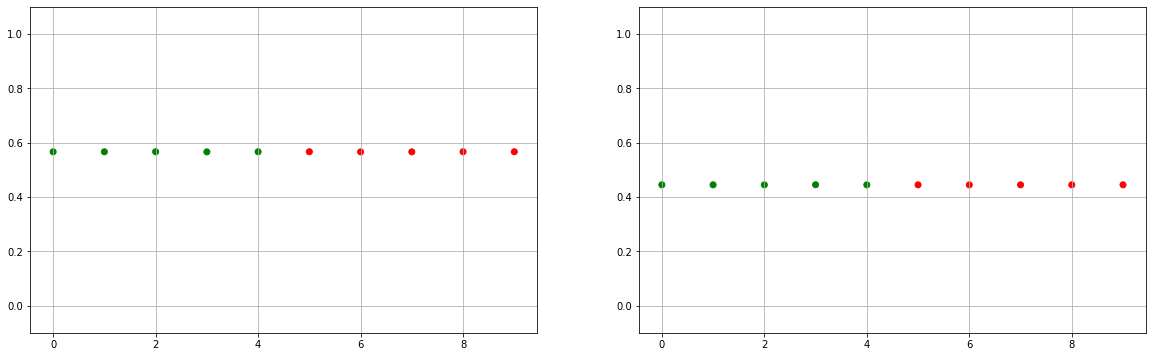

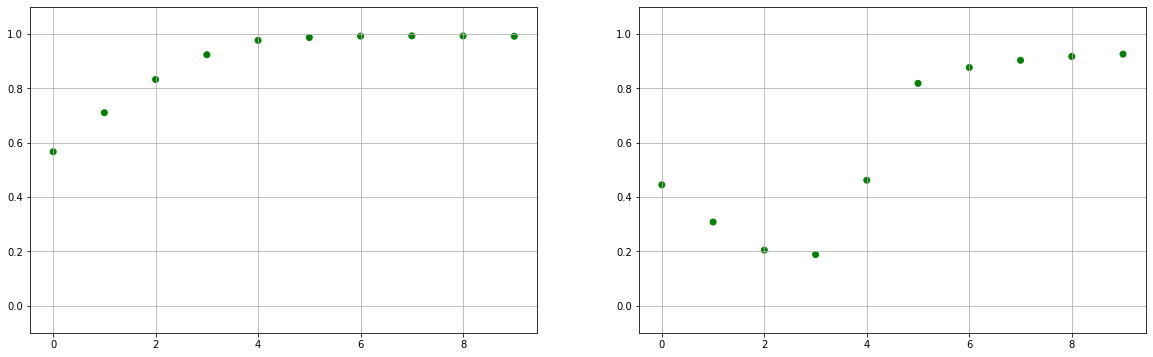

In [41]:
x, y = myqcnn.show_results_annni()

In [48]:
print(myvqe.Hs.mat_Hs[20])

[[ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ... -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]]


In [51]:
np.isclose(myvqe.Hs.mat_Hs[90], myvqe.Hs.mat_Hs[0])

tensor([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]], requires_grad=True)

In [ ]:
dev = myqcnn.device
N = myqcnn.N

In [ ]:
@qml.qnode(dev, interface="jax")
def qcnn_circuit_prob(params_vqe, params):
    qcnn_circuit(params_vqe, myvqe.circuit_fun, myqcnn.params, N, 2)

    return [qml.probs(wires=N - 1), qml.probs(wires=N - 5)]

def compute_cross_entropy(X, Y, params):
    v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

    predictions = v_qcnn_prob(X)
    logprobs = jnp.log(predictions)
    Y = Y.flatten()
    logprobs = (jnp.reshape(logprobs.flatten(), (len(Y),2)))
    
    nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
    ce = - jnp.sum(nll)
    print(ce)
    return predictions

In [ ]:
pre = compute_cross_entropy(X[:2], Y[:2], myqcnn.params)

In [ ]:
pre

In [ ]:
- ( np.log(1 - pre.squeeze()[0][:,1][0]) + np.log(pre.squeeze()[0][:,1][1]) + 
    np.log(1 - pre.squeeze()[1][:,1][0]) + np.log(pre.squeeze()[1][:,1][1]) )

In [ ]:
predictions

In [ ]:
Y[:2][:,0]

In [ ]:
 np.log(1-predictions[0][0][0]) + np.log(1-predictions[1][0][0])

In [ ]:
 np.log(1-predictions[0][0][0]) + np.log(1-predictions[1][0][0]) + np.log(predictions[0][1][0]) + np.log(predictions[1][1][0])

In [ ]:
v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, myqcnn.params))
predictions = v_qcnn_prob(X[:1])

In [ ]:
jnp.array(predictions)

In [ ]:
predictions[0,:][0,:]

In [ ]:
predictions

In [4]:
def get_H(N, L, K):
    """
    Set up Hamiltonian:
            H = J1* (- Σsigma^i_x*sigma_x^{i+1} - (h/J1) * Σsigma^i_z - (J2/J1) * Σsigma^i_x*sigma_x^{i+2}
        
        [where J1 = 1, (h/J1) = Lambda(/L), (J2/J1) = K]

    Parameters
    ----------
    N : int
        Number of spins of the Ising Chain
    L : float
        TODO
    K : float
        TODO

    Returns
    -------
    pennylane.ops.qubit.hamiltonian.Hamiltonian
        Hamiltonian Pennylane class for the (Transverse) Ising Chain
    """
    # Interaction of spins with magnetic field
    H = -L * qml.PauliZ(0)
    for i in range(1, N):
        H = H - L * qml.PauliZ(i)

    # Interaction between spins (neighbouring):
    for i in range(0, N - 1):
        H = H + (-1) * (qml.PauliX(i) @ qml.PauliX(i + 1))
        
    # Interaction between spins (next-neighbouring):
    for i in range(0, N - 2):
        H = H + K * (-1) * (qml.PauliX(i) @ qml.PauliX(i + 2))

    return H

def build_Hs(N, n_states):
    """
    Sets up np.ndarray of pennylane Hamiltonians with different parameters
    total_states = n_states * n_states
    Taking n_states values of K from 0 to 1
    Taking n_states values of L from 0 to 2
    
    Parameters
    ----------
    N : int
        Number of spins of the Ising Chain
    J : float
        Interaction strenght between spins
    n_states : int
        Number of Hamiltonians to generate
    """
    K_states = np.linspace(0, 1, n_states)
    L_states = np.linspace(0, 2, n_states)
    
    Hs = []
    labels = []
    anni_params = []
    for k in K_states:
        for l in L_states:
            anni_params.append([N,l,k])
            Hs.append(get_H(int(N), float(l), float(k)))
            
            # Append the known labels (phases of the model)
            if k == 0:
                if l < 1:
                    labels.append([0,1])
                else:
                    labels.append([1,0])
            elif l == 0:
                if k < .5:
                    labels.append([0,1])
                else:
                    labels.append([0,0])
            else:
                labels.append([None,None])
                
    recycle_rule = []
    k = 0
    while k < n_states:
        recycle_rule.append(np.arange(k*n_states, (k+1)*n_states) )
        k += 1
        if k >= n_states:
            break
        recycle_rule.append(np.arange((k+1)*n_states - 1, k*n_states - 1, -1) )
        k += 1
        
    return Hs, labels, np.array(recycle_rule).flatten(), anni_params

In [17]:
(myvqe.Hs.mat_Hs[10] == myvqe.Hs.mat_Hs[0])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [53]:
Hhs = build_Hs(4, 10)

In [59]:
for hs in Hhs:
    print(qml.matrix(hs[0]))

[[ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j -1.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j
  -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.